In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, load_model
from keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, LSTM, BatchNormalization
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load data
movies = pd.read_csv("/content/movies.csv")
ratings = pd.read_csv("/content/ratings.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
ratings = pd.read_csv("/content/ratings.csv")ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
dataframe = pd.merge(ratings,movies, on ="movieId")
dataframe = dataframe.drop(columns = ["timestamp"])
dataframe.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
dataframe.shape

(100836, 5)

In [ ]:
dataframe.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042529
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


In [ ]:
dataframe.isnull().sum()

userId     0
movieId    0
rating     0
title      0
genres     0
dtype: int64

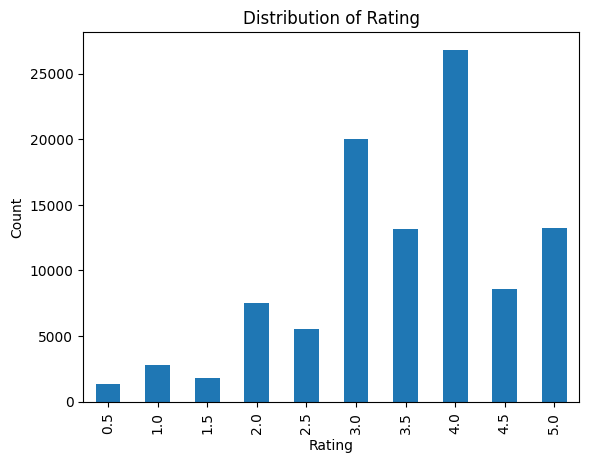

In [ ]:
dataframe['rating'].value_counts().sort_index().plot(kind="bar")
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title("Distribution of Rating")
plt.show()

In recommendation systems, user IDs are often used to represent which users have rated or interacted with which items (movies, products, etc.). By converting these user IDs to indices:

You simplify the input data for neural networks or other models.
Ensure compatibility and consistency when handling user-related data across different parts of the system (e.g., training, inference, evaluation).

In summary, user_id_to_index is a mapping that facilitates the efficient handling and processing of categorical user IDs in machine learning applications, making the data suitable for numerical computations and ensuring consistency across datasets and operations.

The reason we create a mapping like user_id_to_index is primarily for efficient representation and processing within machine learning models, especially neural networks.

## Deep Learning Model

In [ ]:
def preprocess_data(movies, ratings):
    dataframe = pd.merge(ratings, movies, on="movieId").drop(columns=["timestamp"])

    # Tokenize genres
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(movies['genres'])
    movies['genre_tokens'] = tokenizer.texts_to_sequences(movies['genres'])

    max_genres = max(len(tokens) for tokens in movies['genre_tokens'])
    movies['genre_tokens'] = pad_sequences(movies['genre_tokens'], maxlen=max_genres).tolist()

    ratings = ratings.merge(movies[['movieId', 'genre_tokens']], on='movieId', how='left')

    user_ids = ratings['userId'].unique()
    movie_ids = ratings['movieId'].unique()

    user_id_to_index = {id: index for index, id in enumerate(user_ids)}
    movie_id_to_index = {id: index for index, id in enumerate(movie_ids)}

    ratings['user'] = ratings['userId'].apply(lambda x: user_id_to_index[x])
    ratings['movie'] = ratings['movieId'].apply(lambda x: movie_id_to_index[x])

    return ratings, tokenizer, max_genres, len(user_ids), len(movie_ids)

ratings, tokenizer, max_genres, num_users, num_movies = preprocess_data(movies, ratings)

In [ ]:
ratings.head()

,userId,movieId,rating,genre_tokens,user,movie
0,1,1,4.0,"[0, 0, 0, 0, 0, 0, 6, 13, 12, 2, 11]",0,0
1,1,3,4.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 5]",0,1
2,1,6,4.0,"[0, 0, 0, 0, 0, 0, 0, 0, 4, 7, 3]",0,2
3,1,47,5.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 14, 3]",0,3
4,1,50,5.0,"[0, 0, 0, 0, 0, 0, 0, 0, 7, 14, 3]",0,4


In [ ]:
# Split data
X = ratings[['user', 'movie', 'genre_tokens']]
y = ratings['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

user_train = np.array(X_train['user'].tolist())
movie_train = np.array(X_train['movie'].tolist())
genre_train = np.array(X_train['genre_tokens'].tolist())

user_test = np.array(X_test['user'].tolist())
movie_test = np.array(X_test['movie'].tolist())
genre_test = np.array(X_test['genre_tokens'].tolist())

X_train = [user_train, movie_train, genre_train]
X_test = [user_test, movie_test, genre_test]

In [ ]:
# Build model
embedding_size = 100

user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')
genre_input = Input(shape=(max_genres,), name='genre_input')

user_embedding = Embedding(input_dim=num_users, output_dim=embedding_size, name='user_embedding')(user_input)
movie_embedding = Embedding(input_dim=num_movies, output_dim=embedding_size, name='movie_embedding')(movie_input)
genre_embedding = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_size, name='genre_embedding')(genre_input)

user_vector = Flatten()(user_embedding)
movie_vector = Flatten()(movie_embedding)
genre_vector = LSTM(embedding_size)(genre_embedding)

concat = Concatenate()([user_vector, movie_vector, genre_vector])

dense1 = Dense(units=128, activation='relu', kernel_initializer="glorot_normal")(concat)
bn1 = BatchNormalization()(dense1)
dropout1 = Dropout(0.5)(bn1)

dense2 = Dense(units=64, activation='relu', kernel_initializer="glorot_normal")(dropout1)
bn2 = BatchNormalization()(dense2)
dropout2 = Dropout(0.5)(bn2)

dense3 = Dense(units=32, activation='relu', kernel_initializer="glorot_normal")(dropout2)
bn3 = BatchNormalization()(dense3)
dropout3 = Dropout(0.5)(bn3)

output = Dense(1)(dropout3)

model = Model(inputs=[user_input, movie_input, genre_input], outputs=output)
model.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=64, epochs=25, verbose=1, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/25
1009/1009 [==============================] - 16s 12ms/step - loss: 4.6267 - val_loss: 1.0737
Epoch 2/25
1009/1009 [==============================] - 8s 8ms/step - loss: 1.4336 - val_loss: 0.8802
Epoch 3/25
1009/1009 [==============================] - 8s 8ms/step - loss: 1.1315 - val_loss: 0.8222
Epoch 4/25
1009/1009 [==============================] - 9s 9ms/step - loss: 0.9942 - val_loss: 0.8093
Epoch 5/25
1009/1009 [==============================] - 9s 8ms/step - loss: 0.9011 - val_loss: 0.7992
Epoch 6/25
1009/1009 [==============================] - 8s 8ms/step - loss: 0.8305 - val_loss: 0.7851
Epoch 7/25
1009/1009 [==============================] - 8s 8ms/step - loss: 0.7879 - val_loss: 0.7738
Epoch 8/25
1009/1009 [==============================] - 8s 8ms/step - loss: 0.7413 - val_loss: 0.7780
Epoch 9/25
1009/1009 [==============================] - 8s 8ms/step - loss: 0.7080 - val_loss: 0.7819
Epoch 10/25
1009/1009 [==============================] - 8s 8ms/step - loss: 0.6

In [ ]:
# Save model
model.save('movie_recommendation_model.h5')

# Load model
model = load_model('movie_recommendation_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Evaluate model
loss = model.evaluate(X_test, y_test)
print(f'Loss: {loss}')

631/631 [==============================] - 2s 3ms/step - loss: 0.7760
Loss: 0.7760026454925537


In [ ]:
# Predict ratings
predicted_ratings = model.predict(X_test)

# Print predicted and actual ratings
for i, (predicted, actual) in enumerate(zip(predicted_ratings, y_test)):
    print(f"Predicted rating: {predicted[0]}, Actual rating: {actual}")

Streaming output truncated to the last 5000 lines.
Predicted rating: 3.768218994140625, Actual rating: 3.5
Predicted rating: 3.573002815246582, Actual rating: 1.0
Predicted rating: 4.005732536315918, Actual rating: 4.0
Predicted rating: 4.278353691101074, Actual rating: 4.5
Predicted rating: 4.274183750152588, Actual rating: 4.0
Predicted rating: 2.825775623321533, Actual rating: 3.0
Predicted rating: 2.3304953575134277, Actual rating: 2.0
Predicted rating: 4.353884696960449, Actual rating: 4.5
Predicted rating: 3.7151036262512207, Actual rating: 4.5
Predicted rating: 3.428501844406128, Actual rating: 3.5
Predicted rating: 3.1065261363983154, Actual rating: 1.0
Predicted rating: 3.7443132400512695, Actual rating: 4.0
Predicted rating: 4.104856014251709, Actual rating: 3.0
Predicted rating: 3.970050096511841, Actual rating: 4.5
Predicted rating: 4.136110305786133, Actual rating: 2.0
Predicted rating: 3.8907947540283203, Actual rating: 1.5
Predicted rating: 4.419556617736816, Actual rati

In [ ]:
# Function to recommend movies
def recommend_movies(user_id, movie_id, ratings_threshold=4.0):
    user_index = user_id_to_index[user_id]
    movie_index = movie_id_to_index[movie_id]
    genre_tokens = movies[movies['movieId'] == movie_id]['genre_tokens'].values[0]

    user_input = np.array([user_index])
    movie_input = np.array([movie_index])
    genre_input = np.array([genre_tokens])

    predicted_rating = model.predict([user_input, movie_input, genre_input])[0][0]

    if predicted_rating >= ratings_threshold:
        return f"Recommend movie {movie_id} with predicted rating: {predicted_rating}"
    else:
        return f"Do not recommend movie {movie_id} with predicted rating: {predicted_rating}"

# Example usage
print(recommend_movies(user_id=1, movie_id=2))

1/1 [==============================] - 0s 23ms/step
Recommend movie 2 with predicted rating: 4.126946926116943


In [ ]:

# Print the predicted ratings for the test dataset
for i, rating in enumerate(predicted_ratings):
    print(f"Predicted rating for test sample {i}: {rating[0]}")

# Optionally, you can compare with the actual ratings
for i, (predicted, actual) in enumerate(zip(predicted_ratings, y_test)):
    print(f"Predicted rating: {predicted[0]}, Actual rating: {actual}")

Streaming output truncated to the last 5000 lines.
Predicted rating: 3.8896608352661133, Actual rating: 3.5
Predicted rating: 3.6107468605041504, Actual rating: 1.0
Predicted rating: 3.574728012084961, Actual rating: 4.0
Predicted rating: 4.193168640136719, Actual rating: 4.5
Predicted rating: 4.361801624298096, Actual rating: 4.0
Predicted rating: 3.9366672039031982, Actual rating: 3.0
Predicted rating: 2.4254350662231445, Actual rating: 2.0
Predicted rating: 4.094216346740723, Actual rating: 4.5
Predicted rating: 3.6722214221954346, Actual rating: 4.5
Predicted rating: 3.5275590419769287, Actual rating: 3.5
Predicted rating: 3.42106556892395, Actual rating: 1.0
Predicted rating: 3.6099982261657715, Actual rating: 4.0
Predicted rating: 3.954099178314209, Actual rating: 3.0
Predicted rating: 4.16335391998291, Actual rating: 4.5
Predicted rating: 3.214486837387085, Actual rating: 2.0
Predicted rating: 4.0821614265441895, Actual rating: 1.5
Predicted rating: 4.403090476989746, Actual rat

In [ ]:
# Function to recommend top N movies for a user
def recommend_top_n_movies(user_id, n=10):
    user_index = user_id_to_index[user_id]
    user_input = np.array([user_index] * len(movie_ids))
    movie_input = np.array([movie_id_to_index[movie_id] for movie_id in movie_ids])
    genre_input = np.array([movies[movies['movieId'] == movie_id]['genre_tokens'].values[0] for movie_id in movie_ids])

    predicted_ratings = model.predict([user_input, movie_input, genre_input]).flatten()
    top_n_indices = np.argsort(predicted_ratings)[-n:][::-1]

    top_n_movies = [(movie_ids[i], predicted_ratings[i]) for i in top_n_indices]
    return top_n_movies

# Example usage
top_n_recommendations = recommend_top_n_movies(user_id=1, n=5)
for i, (movie_id, predicted_rating) in enumerate(top_n_recommendations, 1):
    print(f"Rank {i}: Movie ID: {movie_id}, Predicted Rating: {predicted_rating}")


304/304 [==============================] - 1s 2ms/step
Rank 1: Movie ID: 140627, Predicted Rating: 4.9482102394104
Rank 2: Movie ID: 132333, Predicted Rating: 4.857133388519287
Rank 3: Movie ID: 6235, Predicted Rating: 4.854367733001709
Rank 4: Movie ID: 1178, Predicted Rating: 4.850395202636719
Rank 5: Movie ID: 7121, Predicted Rating: 4.844719886779785
